## Example - No Branching. Try with StateGraph and MessageGraph. StateGraph is more powerful

[HumanMessage(content='who are you?', id='591093d0-27c2-46cb-b939-dbb787732b9a'), AIMessage(content='I am an artificial intelligence developed by OpenAI, designed to assist with answering questions, providing information, and engaging in various text-based tasks. How can I help you today?', response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 11, 'total_tokens': 46}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_4e2b2da518', 'finish_reason': 'stop', 'logprobs': None}, id='run-1cf8068b-144a-4d8c-bd12-55b8ca351c60-0')]


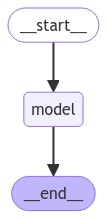

In [1]:
import os
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage,BaseMessage
from langchain_openai import ChatOpenAI
import operator
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph, END, MessageGraph, START
from IPython.display import Image, display

OPENAI_API_KEY="sk-xxxx" # https://platform.openai.com/account/api-keys
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

llm = ChatOpenAI(model='gpt-4o')

class State(TypedDict):
    messages: Annotated[List[str], operator.add]

#builder = StateGraph(State)
builder = MessageGraph()

# def call_llm(state):
#     msg = state['messages']
#     res = llm.invoke(msg)
#     return {'messages':[res]}

#builder.add_node("model", call_llm)
builder.add_node("model", llm)

builder.add_edge("model", END)

builder.add_edge(START, "model")

graph = builder.compile()

#result = graph.invoke({'messages':input_messages})
result = graph.invoke([HumanMessage(content='who are you?')])
print(result)
#graph.invoke({'messages':['who are you?']})

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


## Example - Branching and Customized tools Implementation

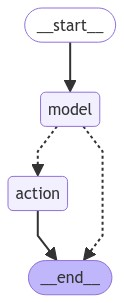

In [2]:
import os
import operator
from langchain_core.tools import tool
from langgraph.graph import END, START
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage,BaseMessage
from langchain_openai import ChatOpenAI
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph, END, MessageGraph, START
from IPython.display import Image, display

#OPENAI_API_KEY="xxxxxx"
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

@tool
def multiply(first_number: int, second_number: int):
    """Multiplies two numbers together."""
    return first_number * second_number

@tool
def add(first_number: int, second_number: int) -> int:
    """Adds two numbers together."""
    return first_number + second_number

tools = [multiply, add]

model = ChatOpenAI(model='gpt-4o')

model_with_tools = model.bind_tools(tools=tools)

builder = MessageGraph()
builder.add_node('model', model_with_tools)
tool_node = ToolNode(tools)
builder.add_node("action", tool_node)
builder.add_edge(START, "model")
builder.add_edge("action", END)

def router(state: list[BaseMessage]):
    tool_calls = state[-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "action"
    else:
        return END

builder.add_conditional_edges("model", router)

graph = builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

#### question is related to multiplication, so the multiply tool was called during graph execution

In [4]:
result=graph.invoke(HumanMessage("What is 123 * 456?"))
print(result)


[HumanMessage(content='What is 123 * 456?', id='c602c9bc-b602-4aa5-93df-61dcab581bac'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CHuS4ResEuHKjEoHIaM4gOZ5', 'function': {'arguments': '{"first_number":123,"second_number":456}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 81, 'total_tokens': 100}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_bc2a86f5f5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c891ddce-43b9-49da-a743-bc49a9a57eec-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 123, 'second_number': 456}, 'id': 'call_CHuS4ResEuHKjEoHIaM4gOZ5', 'type': 'tool_call'}]), ToolMessage(content='56088', name='multiply', id='63a6da07-725a-4550-b148-f39a916d4fba', tool_call_id='call_CHuS4ResEuHKjEoHIaM4gOZ5')]


#### question not related to tools: so no tool is invoked during graph execution

In [5]:
result=graph.invoke(HumanMessage("when did last olympics happen?"))
result


[HumanMessage(content='when did last olympics happen?', id='9d410f5f-b2d7-422a-b784-05356469c659'),
 AIMessage(content='The most recent Olympic Games were the Summer Olympics, which took place in Tokyo, Japan from July 23 to August 8, 2021.', response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 80, 'total_tokens': 111}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_4e2b2da518', 'finish_reason': 'stop', 'logprobs': None}, id='run-b8fb45fc-caf7-47b7-be6c-5938bc8bc74e-0')]